In [1]:
from ResolvedGalaxy import ResolvedGalaxy,MockResolvedGalaxy
import time
import matplotlib.colors as cm
# Default matplotlib color cycle
from matplotlib import rcParams
from astropy.table import Table
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import h5py
import glob
import copy
from astropy.io import fits
from itertools import cycle
from astropy.cosmology import Planck18 as cosmo
from scipy import signal
from tqdm import tqdm
from synthesizer.emission_models import IncidentEmission
from synthesizer.filters import FilterCollection as Filters
from synthesizer.grid import Grid
from synthesizer.kernel_functions import Kernel
from synthesizer.particle.galaxy import Galaxy
from unyt import Hz, erg, Mpc, kpc, Msun, yr, s, arcsecond, nJy, K, Angstrom, unyt_array, um, uJy
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from synthesizer.emission_models.attenuation.igm import Inoue14, Madau96
from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Greybody

Running on Morgan.


In [2]:
cosmo  = FlatLambdaCDM(H0=70, Om0=0.300)


# Define the grid
# Here we are using the Stellar Population Synthesis grid called BPASS (version 2.2.1),
# which includes binary stars, same as the one used to generate all the FLARES photometry
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c17.03"
grid_dir = "/nvme/scratch/work/tharvey/synthesizer/grids/"
grid = Grid(grid_name, grid_dir=grid_dir)

path = '/nvme/scratch/work/tharvey/synthesizer/flares_flags_balmer_project.hdf5'


In [3]:
gal = MockResolvedGalaxy.init_from_h5(h5_name = 'JOF_psfmatched_010_z005p000_4_mock.h5', h5_folder = 'galaxies/')


<class 'str'> {'F435W': {'X_IMAGE': [57.87066396, 134.66708413], 'Y_IMAGE': [88.07751893, 138.00223032], 'A_IMAGE': [6.24369764, 2.45030808], 'B_IMAGE': [3.03322768, 1.02660346], 'THETA_IMAGE': [0.88630414, -1.11500645], 'FLUX_RADIUS': [7.83169646, 2.2175892], 'MAG_AUTO': [30.3472851, 32.09266018], 'MAGERR_AUTO': [0.0, 0.0], 'MAG_BEST': -99, 'MAGERR_BEST': -99, 'MAG_ISO': -99, 'MAGERR_ISO': -99}, 'F606W': {'X_IMAGE': [71.28983866], 'Y_IMAGE': [71.01574564], 'A_IMAGE': [4.26490307], 'B_IMAGE': [3.28099823], 'THETA_IMAGE': [0.62824482], 'FLUX_RADIUS': [5.66791519], 'MAG_AUTO': [26.11176408], 'MAGERR_AUTO': [0.0], 'MAG_BEST': -99, 'MAGERR_BEST': -99, 'MAG_ISO': -99, 'MAGERR_ISO': -99}, 'F775W': {'X_IMAGE': [71.57825095], 'Y_IMAGE': [72.06427495], 'A_IMAGE': [5.95372057], 'B_IMAGE': [4.46735954], 'THETA_IMAGE': [0.57556438], 'FLUX_RADIUS': [6.03675314], 'MAG_AUTO': [23.83337237], 'MAGERR_AUTO': [0.0], 'MAG_BEST': -99, 'MAGERR_BEST': -99, 'MAG_ISO': -99, 'MAGERR_ISO': -99}, 'F814W': {'X_IMA

In [4]:
data = gal.plot_lupton_rgb(red = ['F444W'], green = ['F277W'], blue = ['F150W'], stretch = 0.0001, q = 10)
plt.imshow(data, origin='lower', vmin = 0, vmax = np.percentile(data, 50))

gal.pixedfit_processing(gal_region_use = 'detection', overwrite = True) # Maybe seg map should be from detection image?

fig = gal.plot_gal_region()

                

['hst_acs_f435w', 'hst_acs_f606w', 'hst_acs_f775w', 'hst_acs_f814w', 'hst_acs_f850lp', 'jwst_nircam_f090w', 'jwst_nircam_f115w', 'jwst_nircam_f150w', 'jwst_nircam_f162m', 'jwst_nircam_f182m', 'jwst_nircam_f200w', 'jwst_nircam_f210m', 'jwst_nircam_f250m', 'jwst_nircam_f277w', 'jwst_nircam_f300m', 'jwst_nircam_f335m', 'jwst_nircam_f356w', 'jwst_nircam_f410m', 'jwst_nircam_f444w'] {'hst_acs_f435w': 'crop_F435W_sci.fits', 'hst_acs_f606w': 'crop_F606W_sci.fits', 'hst_acs_f775w': 'crop_F775W_sci.fits', 'hst_acs_f814w': 'crop_F814W_sci.fits', 'hst_acs_f850lp': 'crop_F850LP_sci.fits', 'jwst_nircam_f090w': 'crop_F090W_sci.fits', 'jwst_nircam_f115w': 'crop_F115W_sci.fits', 'jwst_nircam_f150w': 'crop_F150W_sci.fits', 'jwst_nircam_f162m': 'crop_F162M_sci.fits', 'jwst_nircam_f182m': 'crop_F182M_sci.fits', 'jwst_nircam_f200w': 'crop_F200W_sci.fits', 'jwst_nircam_f210m': 'crop_F210M_sci.fits', 'jwst_nircam_f250m': 'crop_F250M_sci.fits', 'jwst_nircam_f277w': 'crop_F277W_sci.fits', 'jwst_nircam_f300m':

KeyError: 'detection'

/nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Galaxy size: 10.30 kpc == 1.64 arcsec == 54.63 pixels
Cutout size is 143 pixels
Found real ResolvedGalaxies to approximate errors from.
Using [370, 36, 531, 830, 778, 16, 478, 575, 806, 801]
[True]
Loading from .h5


Generating RMS error fits: 100%|██████████| 19/19 [00:06<00:00,  2.87it/s]


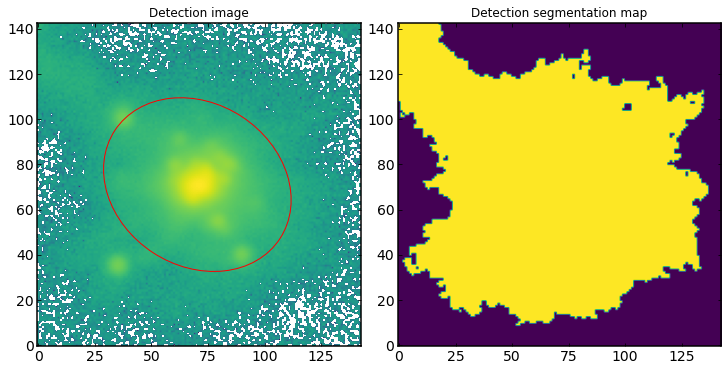

Found 1 objects in detection band F277W+F356W+F444W
added to  <HDF5 file "JOF_psfmatched_010_z005p000_4_mock.h5" (mode r+)> psfs/star_stack/ F435W
added to  <HDF5 file "JOF_psfmatched_010_z005p000_4_mock.h5" (mode r+)> psfs_meta/star_stack/ F435W
added to  <HDF5 file "JOF_psfmatched_010_z005p000_4_mock.h5" (mode r+)> psf_kernels/star_stack/ F435W
added to  <HDF5 file "JOF_psfmatched_010_z005p000_4_mock.h5" (mode r+)> psfs/star_stack/ F606W
added to  <HDF5 file "JOF_psfmatched_010_z005p000_4_mock.h5" (mode r+)> psfs_meta/star_stack/ F606W
added to  <HDF5 file "JOF_psfmatched_010_z005p000_4_mock.h5" (mode r+)> psf_kernels/star_stack/ F606W
added to  <HDF5 file "JOF_psfmatched_010_z005p000_4_mock.h5" (mode r+)> psfs/star_stack/ F775W
added to  <HDF5 file "JOF_psfmatched_010_z005p000_4_mock.h5" (mode r+)> psfs_meta/star_stack/ F775W
added to  <HDF5 file "JOF_psfmatched_010_z005p000_4_mock.h5" (mode r+)> psf_kernels/star_stack/ F775W
added to  <HDF5 file "JOF_psfmatched_010_z005p000_4_mock.

In [ ]:
redshift_code = '010_z005p000' 
galaxy_index = 4

mock_galaxy = MockResolvedGalaxy.init_mock_from_synthesizer(redshift_code, galaxy_index, grid_dir = grid_dir, file_path = path, mock_survey = 'JOF_psfmatched')

In [ ]:
# Reading in the required galaxy particle data
# These are the requested galaxies
# You could also put them as nexted dictionaries!

redshift_index = 3 # redshift index
galaxy_index = 0 # 

tags = {'010_z005p000':['00', '00', '01', '10', '18'], '008_z007p000':['00', '02', '09'], '007_z008p000':['21', '17'], '005_z010p000':['15']}
ids = {'010_z005p000':[12, 96, 1424, 1006, 233], '008_z007p000':[6, 46, 298], '007_z008p000':[111, 16], '005_z010p000':[99]}


# Lets read them from the provided hdf5 file
# It should be the file called flares_flags_balmer_project.hdf5
# Lets start with the first one
def load_galaxy(redshift_code, galaxy_index, path = path):
    #tags = ['010_z005p000', '008_z007p000', '007_z008p000', '005_z010p000']
    #regions = [['00', '00', '01', '10', '18'], ['00', '02', '09'], ['21', '17'], ['15']]
    #ids = [[12, 96, 1424, 1006, 233], [6, 46, 298], [111, 16], [99]]

    regions = {'010_z005p000':['00', '00', '01', '10', '18'], '008_z007p000':['00', '02', '09'], '007_z008p000':['21', '17'], '005_z010p000':['15']}
    ids = {'010_z005p000':[12, 96, 1424, 1006, 233], '008_z007p000':[6, 46, 298], '007_z008p000':[111, 16], '005_z010p000':[99]}

    id = ids[redshift_code][galaxy_index] - 1
    tag = redshift_code
    region = regions[redshift_code][galaxy_index]

    #tag = tags[redshift_index]
    #region = regions[redshift_index][galaxy_index]
    #id = ids[redshift_index][galaxy_index] - 1

    print (tag, region, id)

    zed = float(tag[5:].replace("p", "."))

    with h5py.File(path,'r') as hf:  #opening the hdf5 file
        # coordinates of the stellar particles 
        coordinates = np.array(hf[f"{tag}/{region}/{id}"].get('coordinates'), dtype=np.float64) * Mpc
        # initial masses of the stellar particles
        initial_masses = np.array(hf[f"{tag}/{region}/{id}"].get('initial_masses'), dtype=np.float64) * Msun
        # current masses of the stellar particles, mass change due to mass loss as stars age
        current_masses = np.array(hf[f"{tag}/{region}/{id}"].get('initial_masses'), dtype=np.float64) * Msun
        # ages of stars in log10, which is in units of years
        log10ages = np.array(hf[f"{tag}/{region}/{id}"].get('log10ages'), dtype=np.float64)
        # metallicities of the stars in log10
        log10metallicities = np.array(hf[f"{tag}/{region}/{id}"].get('log10metallicities'), dtype=np.float64)
        # optical depth in the V-band, it is the same prescription as shown in Vijayan+21, which
        # includes the V-band dust optical depth due to the diffuse ISM dust and birth cloud dust
        tau_v = np.array(hf[f"{tag}/{region}/{id}"].get('tau_v'), dtype=np.float64)
        # the smoothing lengths of star particles
        smoothing_lengths = np.array(hf[f"{tag}/{region}/{id}"].get('smoothing_lengths'), dtype=np.float64) * Mpc


        gal = Galaxy(redshift=zed)
        gal.load_stars(
            initial_masses=initial_masses,
            ages=10**log10ages * yr,
            metallicities=10**log10metallicities,
            coordinates=coordinates,
            current_masses=current_masses,
            smoothing_lengths=smoothing_lengths,
            centre=np.zeros(3)*Mpc
        )

    gal.tau_v = tau_v

    return gal

gal = load_galaxy('005_z010p000', galaxy_index)


005_z010p000 15 98


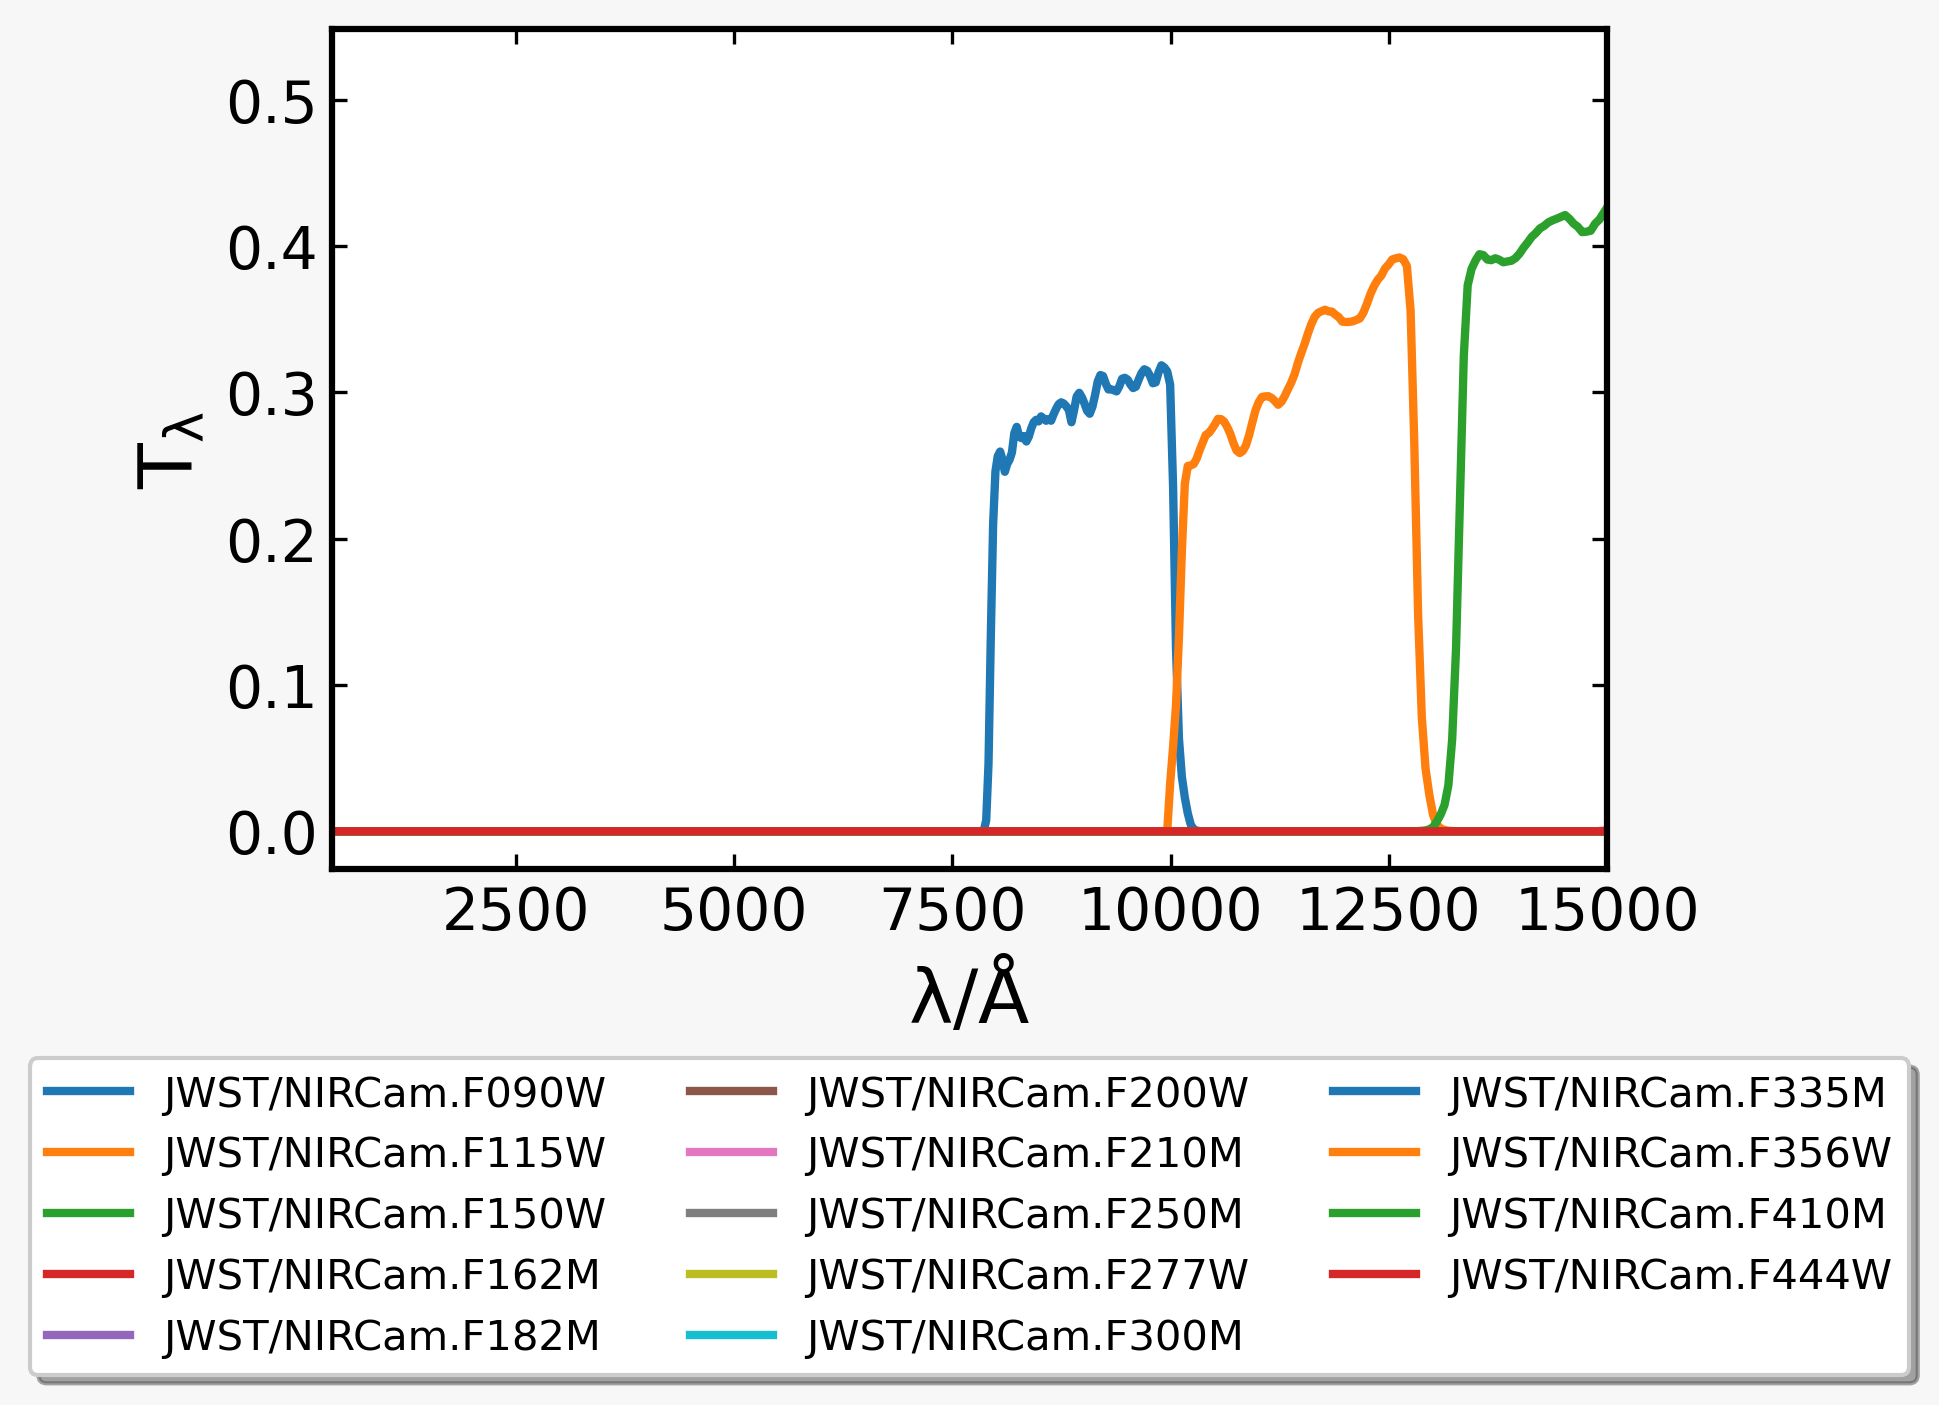

In [ ]:
filter_codes = [
    "JWST/NIRCam.F090W",
    "JWST/NIRCam.F115W",
    "JWST/NIRCam.F150W",
    "JWST/NIRCam.F162M",
    "JWST/NIRCam.F182M",
    "JWST/NIRCam.F200W",
    "JWST/NIRCam.F210M",
    "JWST/NIRCam.F250M",
    "JWST/NIRCam.F277W",
    "JWST/NIRCam.F300M",
    "JWST/NIRCam.F335M",
    "JWST/NIRCam.F356W",
    "JWST/NIRCam.F410M",
    "JWST/NIRCam.F444W",
]

#"HST/ACS_WFC.F435W",
#"HST/ACS_WFC.F606W",
#"HST/ACS_WFC.F814W",
#"HST/ACS_WFC.F775W",
#"HST/ACS_WFC.F850LP",

filters = Filters(filter_codes, new_lam=grid.lam)

fig, ax = filters.plot_transmission_curves()
plt.xlim(400, 15000)
plt.show()


005_z010p000 15 98


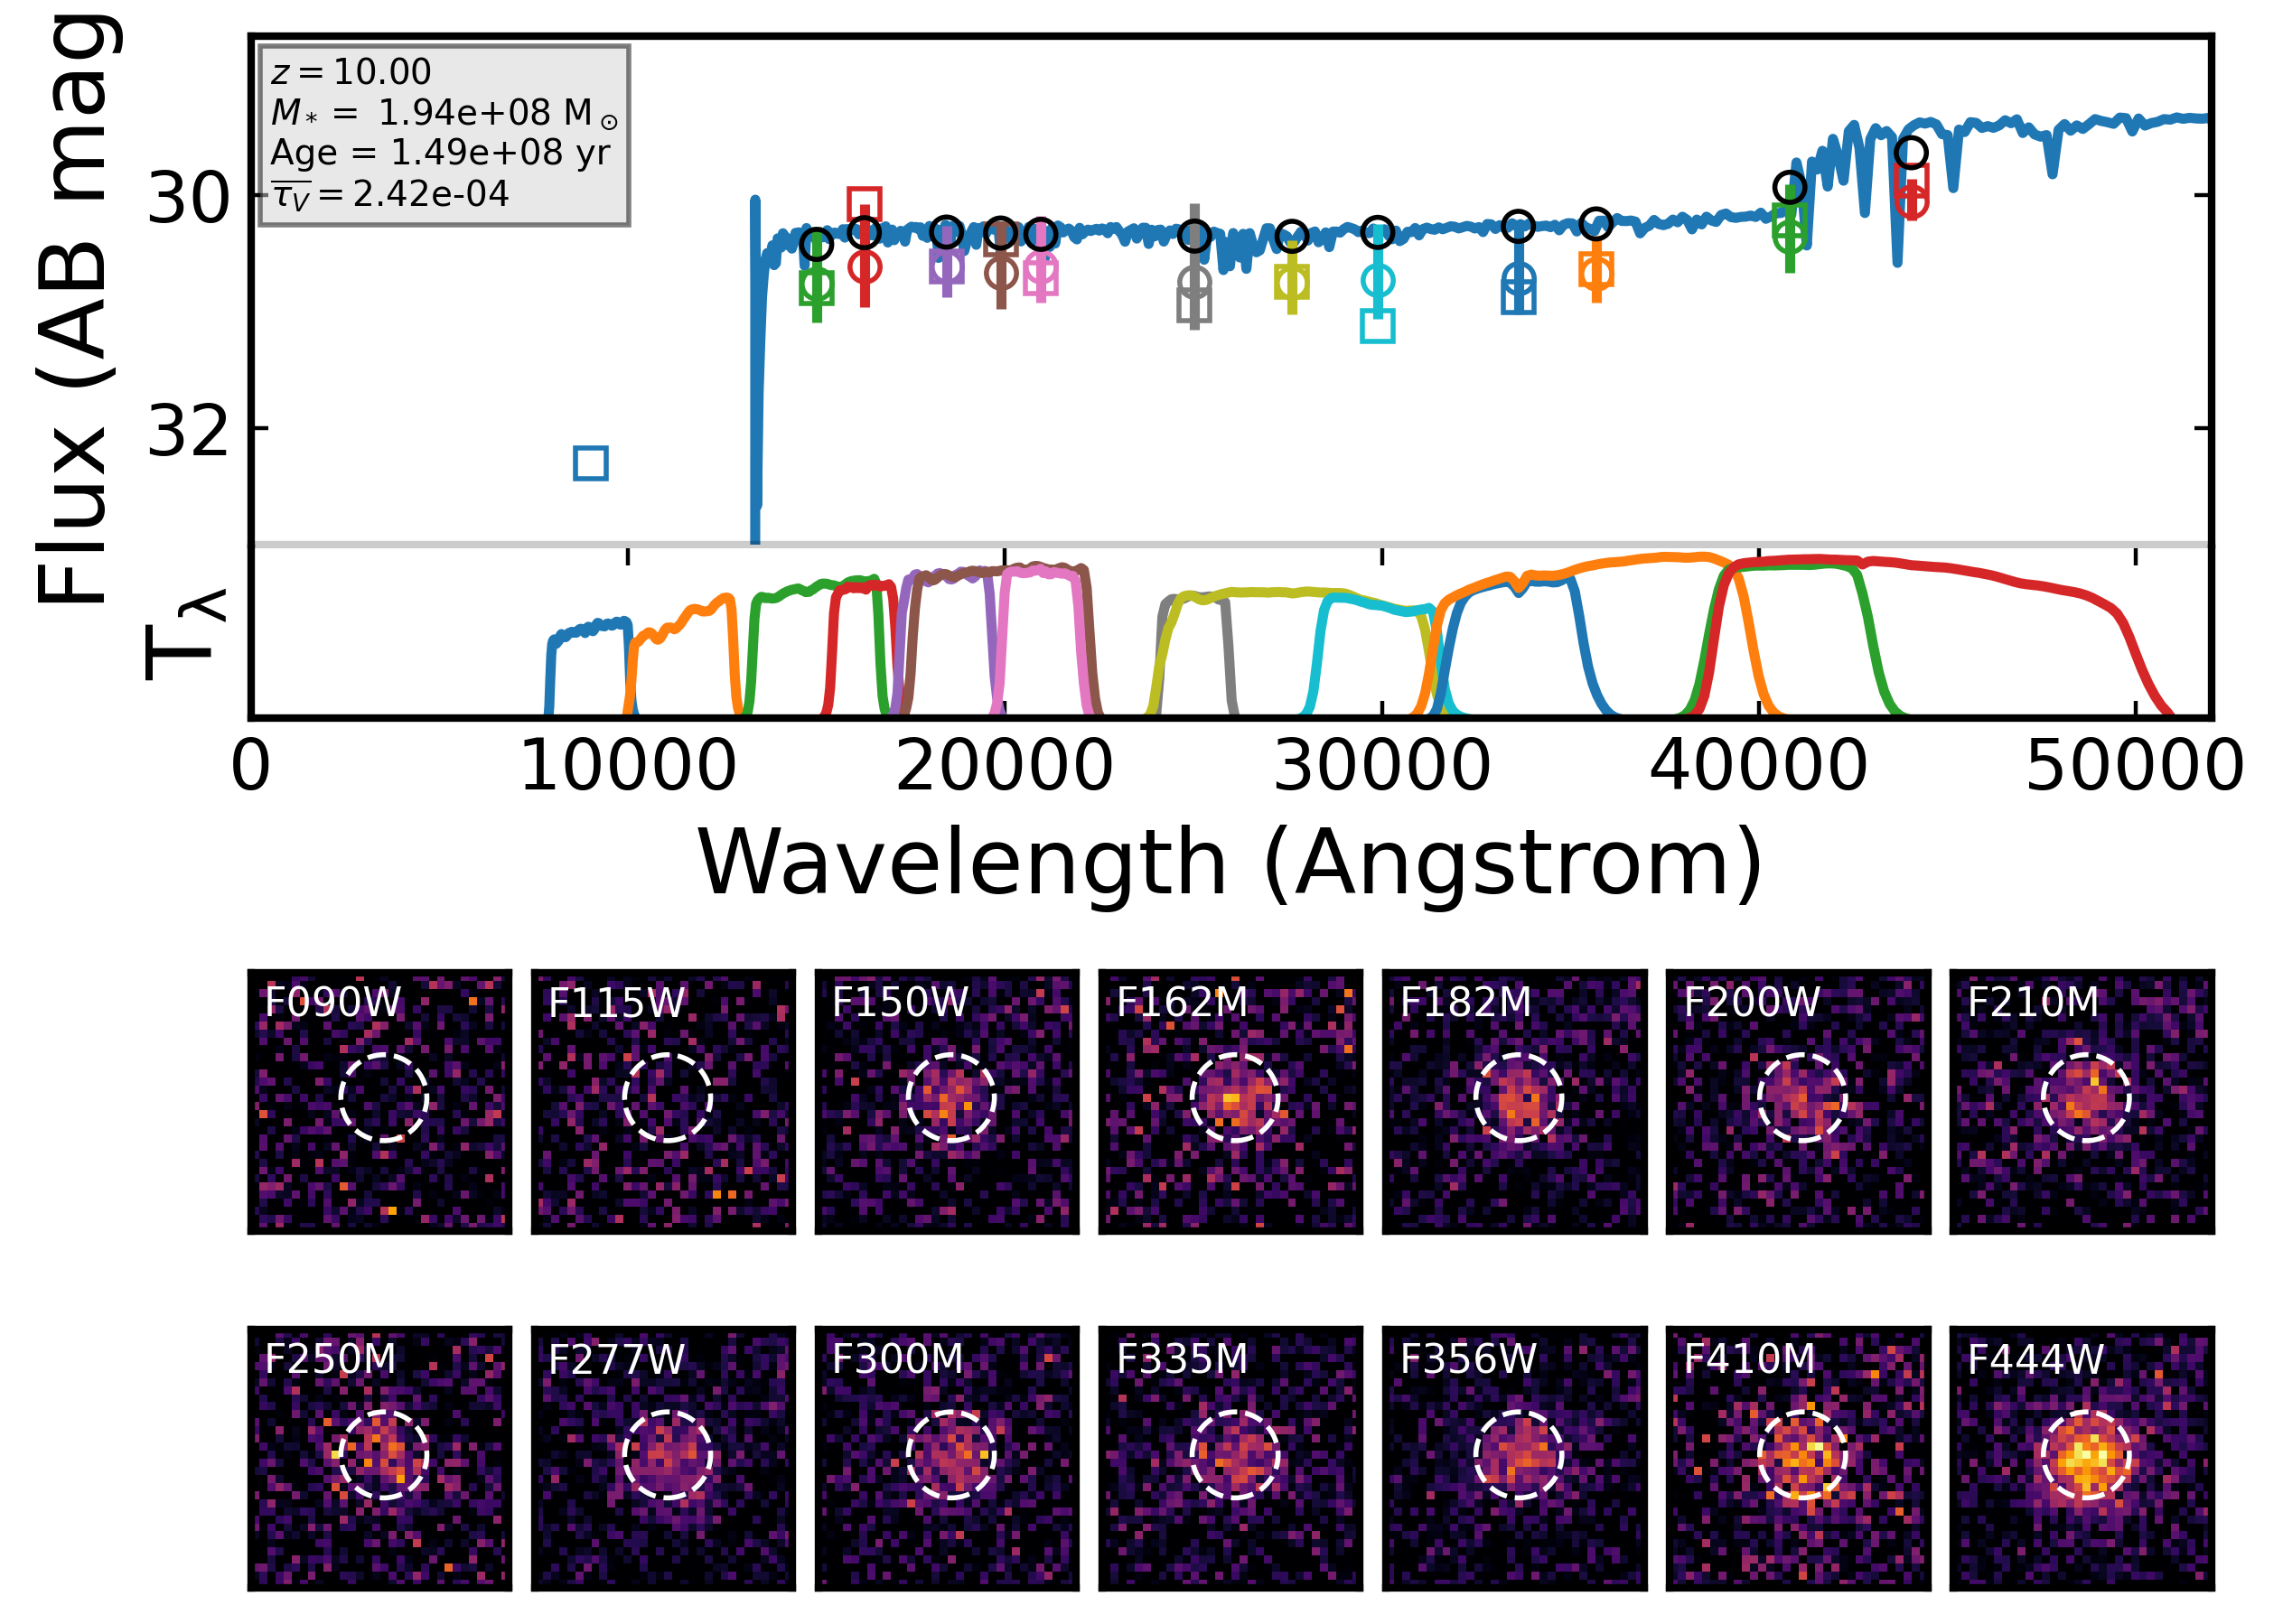

<Figure size 1500x1050 with 0 Axes>

In [ ]:
def model_emission(galaxy, tau_v = None, plot = False):
    emission_model = PacmanEmission(
    grid=grid,
    tau_v=tau_v,
    dust_curve=PowerLaw(slope=-0.7),
    dust_emission=Greybody(30 * K, 1.2))

    gal.stars.get_particle_spectra(emission_model) # takes mask 
    models = gal.stars.particle_spectra.keys()
    for model in models:
        # Generate spectra for each particle for each model component
        gal.stars.particle_spectra[model].get_fnu(cosmo, gal.redshift, igm=Inoue14)
        # Need this for making luminosity images only
        gal.stars.particle_spectra[model].get_photo_lnu(filters)
        

    # Combines the spectra of all the particles
    gal.stars.integrate_particle_spectra()

    if plot:
        gal.stars.plot_spectra(show = True, xlimits = unyt_array([400, 10000], units = Angstrom), ylimits = [1e25, 1e30], figsize = (10, 6))

    gal.stars.get_particle_photo_fnu(filters)

    gal.stars.get_photo_fnu(filters)
    #gal.stars.get_photo_lnu(filters) # unneeded apparently

    return gal


def plot_particle_sed(gal, spec_type = 'total', filters = filters, fig = None, imgs = None, aperture_size_kpc = None, five_sigma_depths = None):
    if fig is None:
        fig, ax = plt.subplots(nrows=2, ncols=1, height_ratios=[3, 1], dpi = 400)
        ax, ax_filt = ax

    else:
        gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
        ax = fig.add_subplot(gs[0])
        ax_filt = fig.add_subplot(gs[1])

        
    if spec_type == 'all':
        spec_type = gal.stars.spectra.keys()
    elif type(spec_type) == str:
        spec_type = [spec_type]
    for s in spec_type:
        sed = gal.stars.spectra[s]
        phot = gal.stars.photo_fnu[s]
        ax.plot(sed.obslam, -2.5* np.log10(sed.fnu) + 31.40, label = s)
        ax.scatter(filters.pivot_lams.ndarray_view(), -2.5*np.log10(phot.photo_fnu.to(nJy)) + 31.40, marker = 'o', color = 'black', facecolors='none', zorder = 10)

    # default color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = colors*5
    markers = ['s', 'o', 'v', 'D', 'P', 'X', 'H', 'd', 'p', 'x', 'h', '^', '<', '>', 'v']
    if imgs is not None:
        if type(imgs) != list:
            imgs = [imgs]
        for img_pos, img in enumerate(imgs):
            for pos, key in enumerate(img.keys()):
                unit = img[key].units
                if unit != nJy:
                    img[key].arr = (img[key].arr * unit).to(nJy).value
                    img[key].units = nJy

                if aperture_size_kpc is not None:
                    center = img[key].arr.shape[0] / 2
                    signal = img[key].get_signal_in_aperture(aperture_radius = aperture_size_kpc, aperture_cent = (center, center))
                    ax.plot(filters.pivot_lams[pos], -2.5*np.log10(signal) + 31.40, marker = markers[img_pos], color = 'none', markeredgecolor = colors[pos])

                if five_sigma_depths is not None and img_pos == 1:
                    flux = signal
                    flux_err = five_sigma_depths[key]/5
                    mag_err_list = [[np.abs(2.5*np.log10(flux/(flux-flux_err)))], [np.abs(2.5 * np.log10(1+flux_err/flux))]]
                    #print(mag_err_list)
                    ax.errorbar(filters.pivot_lams[pos], -2.5*np.log10(flux) + 31.40, yerr = mag_err_list, marker = 'none', color = colors[pos])



    ax.set_xlim(0, 52000)
    ax_filt.set_xlim(0, 52000)
    ax.set_xticks([])
    
    vals = -2.5*np.log10(phot.photo_fnu.to(nJy)) + 31.40

    ymin = np.min(vals) - 1.0
    ymax = np.max(vals) + 1.0
    if ymax > 33:
        ymax = 33

    ax.set_ylim(ymax, ymin)

    

    filters.plot_transmission_curves(ax = ax_filt)
    ax_filt.set_xlabel("Wavelength (Angstrom)")
    ax.set_ylabel("Flux (AB mag)")
    # Remove upper and right axes
    ax_filt.spines['top'].set_visible(False)
    ax.spines['bottom'].set_alpha(0.2)

    fig.subplots_adjust(hspace=0.01)
    # No legends
    ax_filt.legend().remove()
    ax_filt.set_ylim(0.01, None)
    ax_filt.set_yticklabels('')
    ax_filt.set_yticks([])


    text = '\n'.join((f'$z = {gal.redshift:.2f}$',
                        f'$M_* = $ {gal.stellar_mass.value:.2e} ${gal.stellar_mass.units.latex_repr}$',
                        f'Age = {gal.stellar_mass_weighted_age:.2e}',
                        rf'$\overline{{\tau_V}} = ${gal.tau_v.mean():.2e}'
    ))
    props = dict(boxstyle='square', facecolor='lightgrey', alpha=0.5)
    ax.text(0.01, 0.96, text, transform=ax.transAxes, fontsize=7,
            verticalalignment='top', bbox=props)

    if len(spec_type) > 1:
        ax.legend(frameon = False)
    return fig

#fig = plot_particle_sed(gal, spec_type = 'total', filters = filters)

def make_images(galaxy, cutout_size = 100, resolution = 0.03 * arcsecond, 
                sph_kernel = Kernel(),  img_type = "smoothed",
                spectra_type = 'total', psfs = None):
    
    # Calculate size and resolution of the cutouts
    re = 1
    d_A = cosmo.angular_diameter_distance(gal.redshift)
    pix_scal = u.pixel_scale(resolution.to(arcsecond).value*u.arcsec/u.pixel)
    re_as = (re * u.pixel).to(u.arcsec, pix_scal)
    re_kpc = (re_as * d_A).to(u.kpc, u.dimensionless_angles())

    resolution = re_kpc.value * kpc
    width = cutout_size * resolution

    # Get the SPH kernel

    kernel_data = sph_kernel.get_kernel()

    

    # Get the image
    imgs = gal.get_images_flux(
        resolution,
        fov=width,
        img_type=img_type,
        stellar_photometry=spectra_type,
        blackhole_photometry=None,
        kernel=kernel_data,
        kernel_threshold=1,
    )

    if psfs is not None:
        # Apply the PSFs
        psf_imgs = imgs.apply_psfs(psfs)
    else:
        psf_imgs = imgs

    return psf_imgs

def apply_noise(images, radius = 0.16 * u.arcsec,
                    depth_file = '/raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/JOF_depths.ecsv',
                    return_depths = False):

    d_A = cosmo.angular_diameter_distance(gal.redshift)
    radius_kpc = (radius * d_A).to(u.kpc, u.dimensionless_angles())
    radius_kpc = radius_kpc.value * kpc

    snrs = {f: 5 for f in images.keys()}  

    table = Table.read(depth_file, format='ascii.ecsv')
    # Select 'all' region column
    table = table[table['region'] == 'all']
    #band_depths:
    bands = [i.split('.')[1] for i in filters.filter_codes]
    band_depths = {}
    for band in bands:
        row = table[table['band'] == band]
        data = row['median_depth']
        band_depths[band] = data * u.ABmag
    wavs = {f:np.squeeze(filters.pivot_lams[pos].value) for pos, f in enumerate(bands)}
    # Convert to uJy from AB mag
    depths = {img_key:band_depths[f].to(u.uJy, equivalencies=u.spectral_density(wavs)).value * uJy for f, img_key in zip(bands, images.keys())}
    depths = {k: v[0] for k, v in depths.items()}

    #print(depths)

    noise_app_imgs = images.apply_noise_from_snrs(snrs=snrs, depths=depths, aperture_radius=radius_kpc, sqrt = False, trunc = None)

    if return_depths:
        return noise_app_imgs, depths
    
    return noise_app_imgs

def apply_psf(images,  psfs_dir = '/nvme/scratch/work/tharvey/PSFs/JOF/'):
    psfs = {}
    files = glob.glob(f'{psfs_dir}/*_psf.fits')
    bands = [i.split('.')[1] for i in filters.filter_codes] 
    for band, code in zip(bands, filter_codes):
        psf_file = [f for f in files if band in f][0]
        psf = fits.open(psf_file)[0].data
        psfs[code] = psf
    
    # Apply the PSFs
    psf_imgs = images.apply_psfs(psfs)
    
    return psf_imgs

def plot_images(imgs, filters = filters, fig = None, max_on_row = 7, aper_radius = 0.16 * u.arcsec):
    if fig is None:
        fig = plt.figure(figsize=(20, 10), dpi = 400, facecolor='w')
    n = len(imgs)
    n_rows = int(np.ceil(n / max_on_row))
    n_cols = min(n, max_on_row)
    gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.1, hspace=0.1)

    vmax = 0
    for img in imgs.values():
        up = np.percentile(img.arr, 99.9)
        if up > vmax:
            vmax = up
    # Convert vmax to nJy

    #Broken after this
    units = imgs[filters.filter_codes[0]].units
    vmax = vmax * units

    for i, (img, fcode) in enumerate(zip(imgs, filters.filter_codes)):
        ax = fig.add_subplot(gs[i])
        unit = img.units
        img_data = img.arr * unit

        ax.imshow(img_data.to(nJy), cmap='inferno', vmin = 0, vmax = vmax.to(nJy), origin='lower')
        #ax.set_title(fcode)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(0.05, 0.95, fcode.split('.')[1], color = 'white', transform=ax.transAxes, fontsize = 8, ha = 'left', va = 'top')
        #ax.set_title(filters[i].name)
        if aper_radius is not None:
            from matplotlib.patches import Circle
            center = img_data.shape[0] / 2
            pixel_scale = 0.03 * u.arcsecond
            ax.add_patch(Circle((center, center), aper_radius/pixel_scale, fill = False, edgecolor = 'white', linestyle = 'dashed'))
    return fig

def pretty_plot(gal, images, filters, spec_type, depths = None):

    # Create an info box
    fig = plt.Figure(figsize = (7, 5), dpi = 400, facecolor='w')
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
    sed_fig = fig.add_subfigure(gs[0])
    img_fig = fig.add_subfigure(gs[1])

    sed_fig = plot_particle_sed(gal, spec_type = spec_type, filters = filters, 
                                fig = sed_fig, imgs = images,
                                aperture_size_kpc = 0.6657108613771668 * kpc,
                                five_sigma_depths = depths)
    img_fig = plot_images(images[0], filters = filters, fig = img_fig)

    return fig

#for redshift_code in tags.keys():
#    for pos in range(len(tags[redshift_code])):
redshift_code = '005_z010p000' 
pos = 0

# '010_z005p000' - 5
# '008_z007p000' - 3
# '007_z008p000' - 2
# '005_z010p000' - 1

def flux_within_1sigma(noisy_img, psf_img, depth):
    good = []
    for key in noisy_imgs.keys():
        error = depth[key]/5
        center = noisy_img[key].arr.shape[0] / 2
        flux = noisy_img[key].get_signal_in_aperture(aperture_radius =  0.6657108613771668 * kpc, aperture_cent = (center, center)).to(uJy)
        flux_before = psf_img[key].get_signal_in_aperture(aperture_radius =  0.6657108613771668 * kpc, aperture_cent = (center, center)).to(uJy)
        #print(key, flux, flux_before, error)

        if flux_before - error < flux < flux_before + error:
            i = True

        else:
            i = False

        good.append(i)
        #print(key, i, -2.5*np.log10(flux.to(nJy).value) + 31.40, -2.5*np.log10(flux_before.to(nJy).value) + 31.40)
        
    return good
 

gal = load_galaxy(redshift_code, pos)
gal = model_emission(gal, tau_v = gal.tau_v)
imgs = make_images(gal, cutout_size = 32)
    
psf_imgs = apply_psf(imgs)

test_errors = False
if test_errors:
    total_good = []
    for i in tqdm(range(1000)):
        noisy_imgs, depths = apply_noise(psf_imgs, return_depths = True)
        good = flux_within_1sigma(noisy_imgs, psf_imgs, depths)
        total_good.extend(good)
    
    print(f'Total good: {100 * np.sum(total_good)/len(total_good)}%')


else:
    noisy_imgs, depths = apply_noise(psf_imgs, return_depths = True)


fig = pretty_plot(gal, [noisy_imgs, psf_imgs], filters, 'total', depths = depths)
fig.savefig(f'plots/simulated_galaxies/{redshift_code}_{pos}.png', bbox_inches = 'tight')
fig
###gal = model_emission(gal)

#imgs = make_images(gal)
#psf_imgs = apply_psf(imgs)

#noisy_imgs = apply_noise(psf_imgs)

#fig = pretty_plot(gal, noisy_imgs, filters, 'total')

#fig.savefig(f'plots/simulated_galaxies/{tag}_{region}_{id}.png', bbox_inches = 'tight')

In [ ]:

half_light_radius = gal.stars.get_flux_radius('total', f'JWST/NIRCam.F277W', 0.95).to(kpc)

size_bands = ['JWST/NIRCam.F277W', 'JWST/NIRCam.F356W', 'JWST/NIRCam.F444W']
half_light_radius = np.max([gal.stars.get_flux_radius('total', band, 0.95).to(kpc) for band in size_bands]) * kpc


print(f'{half_light_radius:.2f}')

# convert to arcseconds
half_light_radius = half_light_radius.to_astropy()
d_A = cosmo.angular_diameter_distance(gal.redshift)
half_light_radius = (half_light_radius / d_A).to(u.arcsec, u.dimensionless_angles())
print(f'{half_light_radius:.2f}')

# convert to pixels
pixel_scale = 0.03 * u.arcsecond
half_light_radius = (half_light_radius / pixel_scale)
print(f'{half_light_radius:.2f} pixels')

# Cutout size 2 * 95% flux radius + 10% padding
cutout_size = np.ceil(2 * half_light_radius + 0.1 * 2 * half_light_radius)
print(f'{cutout_size:.2f} pixels')

5.67 kpc
1.36 arcsec
45.44 pixels
100.00 pixels


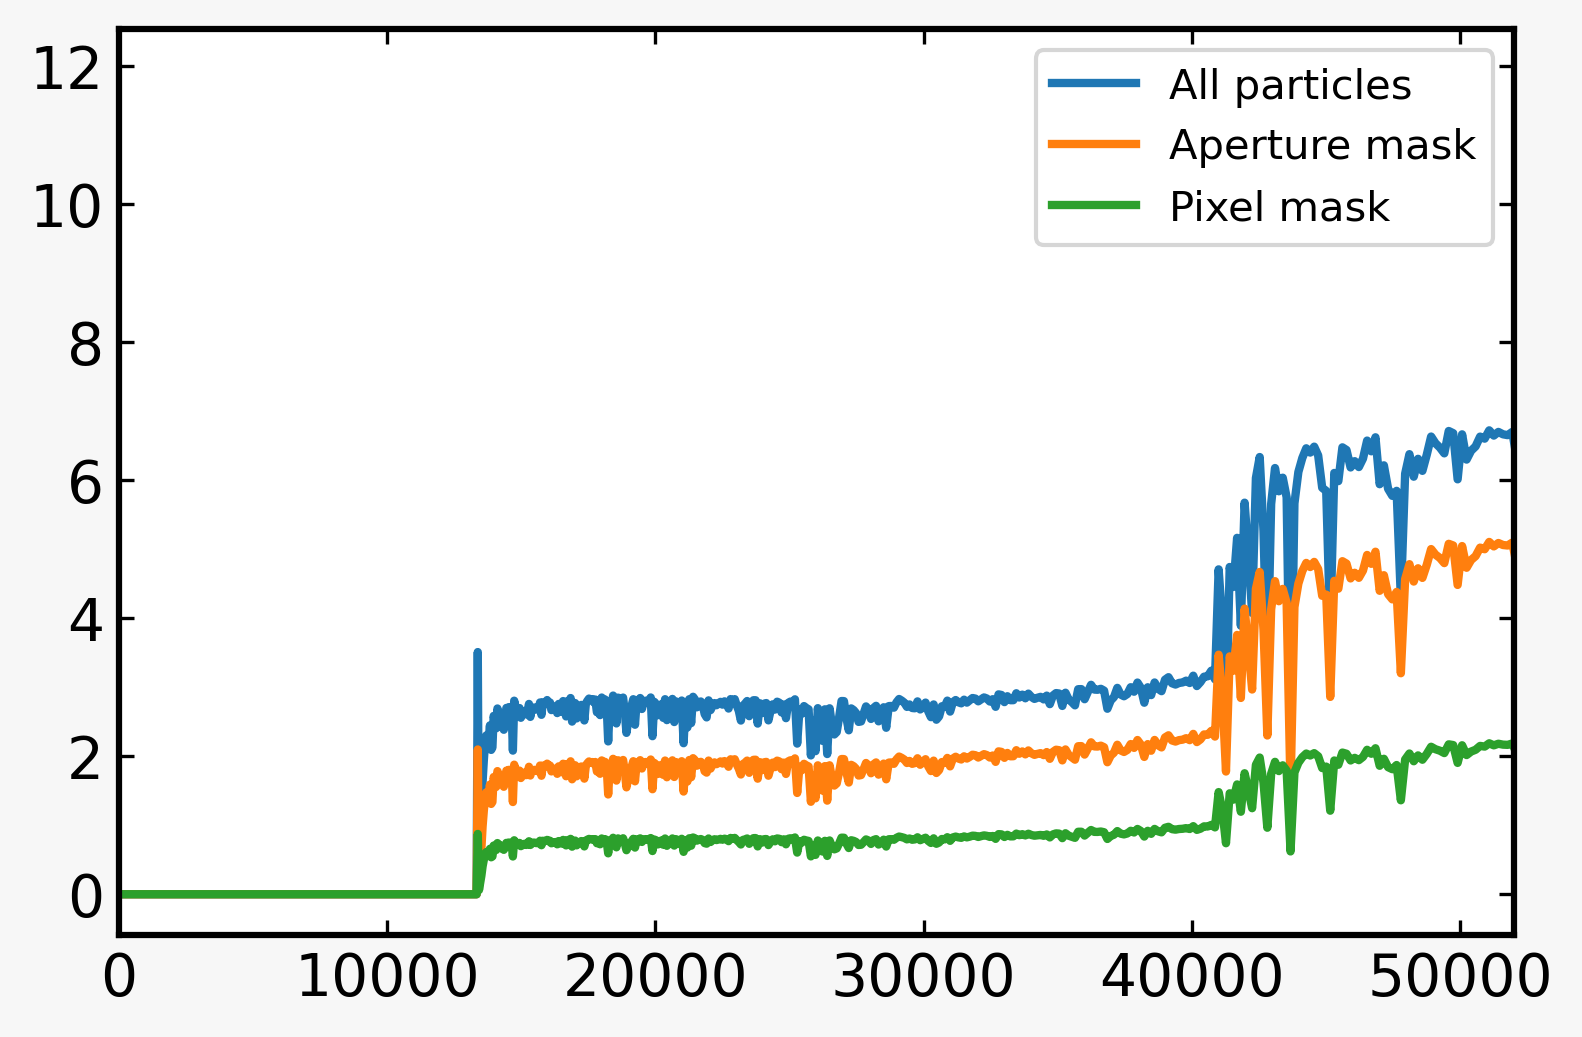

In [ ]:
def convert_coordinates(coordinates, redshift, pixel_scale = 0.03 * u.arcsecond):
    '''

    Convert physical coordinates to pixel coordinates

    '''
    d_A = cosmo.angular_diameter_distance(redshift)
    coords_arcsec = (coordinates / d_A).to(u.arcsec, u.dimensionless_angles())
    coords_pixels = (coords_arcsec / pixel_scale).value
    return coords_pixels

def apply_pixel_coordinate_mask(gal, pixel_mask, pixel_scale = 0.03 * u.arcsecond):
    coords = gal.stars.centered_coordinates.to_astropy().to(u.kpc)

    coords = convert_coordinates(coords, gal.redshift)

    coords_2d_pixels = coords[:, [1, 0]] # x, y 

    coords_2d_pixels[:, 0] = coords_2d_pixels[:, 0] + np.shape(pixel_mask)[1] / 2
    coords_2d_pixels[:, 1] = coords_2d_pixels[:, 1] + np.shape(pixel_mask)[0] / 2

    #print(coords_2d_pixels)


    # Bin coordinates into grid of shape pixel_mask.shape with the same pixel scale
    # Calculate which pixel each coordinate belongs to
    x_bins = np.digitize(coords_2d_pixels[:, 0], np.linspace(0, pixel_mask.shape[0], pixel_mask.shape[0] + 1)) - 1
    y_bins = np.digitize(coords_2d_pixels[:, 1], np.linspace(0, pixel_mask.shape[1], pixel_mask.shape[1] + 1)) - 1

    masks = []
    for i, j in zip(x_bins, y_bins):
        if i < 0 or i >= pixel_mask.shape[0] or j < 0 or j >= pixel_mask.shape[1]:
            masks.append(False)
        else:
            masks.append(pixel_mask[j, i])
            #print(i, j, pixel_mask[j, i])

    return np.array(masks, dtype = bool)

def get_spectra_in_mask(gal, spectra_type = 'total', aperture_mask_radii = None, pixel_mask = None, pixel_scale = 0.03 * u.arcsecond):
    if aperture_mask_radii is not None and pixel_mask is not None:
        raise ValueError('Must provide only one of aperture_mask or pixel_mask')
    elif aperture_mask_radii is None and pixel_mask is None:
        raise ValueError('Must provide either aperture_mask or pixel_mask')

    assert (type(aperture_mask_radii) == type(unyt_array) or type(aperture_mask_radii) == u.Quantity) or type(pixel_mask) == np.ndarray

    if aperture_mask_radii is not None:
        coords = gal.stars.centered_coordinates.to_astropy().to(u.kpc)

        if type(aperture_mask_radii) == u.Quantity:
            if aperture_mask_radii.unit == u.arcsec:
                aperture_mask_radii /= pixel_scale
            # Convert to pixels if not providing a unyt quantity
            coords = convert_coordinates(coords, gal.redshift, pixel_scale = pixel_scale)

        mask = coords[:, 0]**2 + coords[:, 1]**2 < aperture_mask_radii**2

    if pixel_mask is not None:
        mask = apply_pixel_coordinate_mask(gal, pixel_mask)
    
    spectra_mask = gal.stars.particle_spectra['total'].fnu[mask]
    spectra_mask_total = np.sum(spectra_mask, axis = 0)

    return spectra_mask_total

coords = gal.stars.centered_coordinates.to_astropy().to(u.kpc)

coords = convert_coordinates(coords, gal.redshift)

coords_2d = coords[:, [0, 1]]
# Make a 2D plot of the galaxy

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(coords_2d[:, 1], coords_2d[:, 0], 'o', markersize = 1)


coord_mask = np.zeros((64, 64), dtype = bool)
coord_mask[31:33, 31:33] = True
coord_mask[28:31, 32:36] = True

mask = apply_pixel_coordinate_mask(gal, coord_mask)

ax.plot(coords[mask, 1], coords[mask, 0], 'o', markersize = 1, color = 'red')

ax.imshow(coord_mask, extent = [-np.shape(coord_mask)[1]/2, np.shape(coord_mask)[1]/2, -np.shape(coord_mask)[0]/2, np.shape(coord_mask)[0]/2,], origin = 'lower', alpha = 0.5)
ax.set_xlabel('X (pixels')
ax.set_ylabel('Y (pixels')

plt.show()
plt.close()

aperture_spectra = get_spectra_in_mask(gal, aperture_mask_radii = 0.16 * u.arcsec, spectra_type = 'total')
pixel_spectra = get_spectra_in_mask(gal, pixel_mask = coord_mask)

plt.plot(gal.stars.particle_spectra['total'].obslam,  np.sum(gal.stars.particle_spectra['total'].fnu, axis = 0), label = 'All particles')
plt.plot(gal.stars.particle_spectra['total'].obslam, aperture_spectra, label = 'Aperture mask')
plt.plot(gal.stars.particle_spectra['total'].obslam, pixel_spectra, label = 'Pixel mask')
plt.legend()

plt.ylim()
plt.xlim(0, 52000)

plt.show()

In [ ]:
a = 1/np.sqrt(noisy_imgs[filter_codes[-1]].weight_map) * uJy

err_array = noisy_imgs[filter_codes[-1]].noise_arr

print(np.std(err_array), a)


5.750051570999759e-05 μJy 5.9530243032413626e-05 μJy


In [ ]:
radius = 0.16 * u.arcsec
d_A = cosmo.angular_diameter_distance(gal.redshift)
radius_kpc = (radius * d_A).to(u.kpc, u.dimensionless_angles())
radius_kpc = radius_kpc.value * kpc
print(radius_kpc)

depth_file = '/raid/scratch/work/austind/GALFIND_WORK/Depths/NIRCam/v11/JOF/0.32as/n_nearest/JOF_depths.ecsv'
table = Table.read(depth_file, format='ascii.ecsv')
# Select 'all' region column
table = table[table['region'] == 'all']
#band_depths:
bands = [i.split('.')[1] for i in filters.filter_codes]
band_depths = {}
for band in bands:
    row = table[table['band'] == band]
    data = row['median_depth']
    band_depths[band] = data * u.ABmag
wavs = {f:np.squeeze(filters.pivot_lams[pos].value) for pos, f in enumerate(bands)}
# Convert to uJy from AB mag
depths = {img_key:band_depths[f].to(u.uJy, equivalencies=u.spectral_density(wavs)).value * uJy for f, img_key in zip(bands, imgs.keys())}
depths = {k: v[0] for k, v in depths.items()}


print('filter psf_flux noisy_flux 1_sigma_error(from depth)')
for key in noisy_imgs.keys():
    
    unit = noisy_imgs[key].units
    if unit != uJy:
        noisy_imgs[key].arr = (noisy_imgs[key].arr * unit).to(uJy).value
        noisy_imgs[key].units = uJy

    center = noisy_imgs[key].arr.shape[0] / 2
    signal = noisy_imgs[key].get_signal_in_aperture(aperture_radius = radius_kpc, aperture_cent = (center, center))
    signal_psf = psf_imgs[key].get_signal_in_aperture(aperture_radius = radius_kpc, aperture_cent = (center, center))
    print(key, f'{signal_psf.to(nJy):.2f}', f'{signal.to(nJy):.2f}', f'{depths[key].to(nJy)/5:.2f}')
    #print(-2.5 * np.log10(np.sum(noisy_imgs[key].arr)) + 31.40)

    #print(key, np.min(noisy_imgs[key].arr), np.max(noisy_imgs[key].arr))
print(depths)

0.6657108613771668 kpc
filter psf_flux noisy_flux 1_sigma_error(from depth)
JWST/NIRCam.F090W 0.00 nJy -0.57 nJy 0.87 nJy
JWST/NIRCam.F115W 0.00 nJy -1.49 nJy 0.81 nJy
JWST/NIRCam.F150W 1.81 nJy 2.38 nJy 0.65 nJy
JWST/NIRCam.F162M 2.08 nJy 2.37 nJy 0.80 nJy
JWST/NIRCam.F182M 2.07 nJy 3.45 nJy 0.57 nJy
JWST/NIRCam.F200W 1.97 nJy 3.46 nJy 0.66 nJy
JWST/NIRCam.F210M 2.07 nJy 2.62 nJy 0.68 nJy
JWST/NIRCam.F250M 1.83 nJy 1.78 nJy 0.85 nJy
JWST/NIRCam.F277W 1.82 nJy 1.35 nJy 0.51 nJy
JWST/NIRCam.F300M 1.86 nJy 1.37 nJy 0.67 nJy
JWST/NIRCam.F335M 1.89 nJy 2.08 nJy 0.62 nJy
JWST/NIRCam.F356W 1.95 nJy 1.82 nJy 0.51 nJy
JWST/NIRCam.F410M 2.62 nJy 4.14 nJy 0.89 nJy
JWST/NIRCam.F444W 3.45 nJy 3.60 nJy 0.56 nJy
{'JWST/NIRCam.F090W': unyt_quantity(0.00434548, 'μJy'), 'JWST/NIRCam.F115W': unyt_quantity(0.0040624, 'μJy'), 'JWST/NIRCam.F150W': unyt_quantity(0.00325616, 'μJy'), 'JWST/NIRCam.F162M': unyt_quantity(0.00400232, 'μJy'), 'JWST/NIRCam.F182M': unyt_quantity(0.0028527, 'μJy'), 'JWST/NIRCam.F200W